# 1. Pozyskiwanie danych

In [1]:
#zewnętrzny program do rysowania etykiet i zapisywania ich w postaci plików JSON
!labelme

# 2. Wczytywanie obrazów

In [2]:
#import potrzebynch pakietów
import tensorflow as tf
import json
import numpy as np
import os
import cv2

#uniknięcie zżerania pamięci
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

#wczytanie obrazów do zmiennej
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
images.as_numpy_iterator().next()

#funkcja wczytująca obraz
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

#przygotowanie zmiennej do dalszych operacji
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# 3. Podział danych

### 3.1. Ustalenie podziału obrazów na poszczególne foldery

In [3]:
x = 200 #ilość zdjęć wejściowych
train_folder = x*.75
val_folder = x*.15
test_folder = x*.10
print('Train:',train_folder,', Val:',val_folder,', Test:',test_folder)

Train: 150.0 , Val: 30.0 , Test: 20.0


### 3.2. Przeniesienie wcześniej utworzonych etykiet do odpowiednich folderów

In [4]:
#pętla przenosząca wszystkie etykiety do odpowiednich folderów na podstawie nazw plików
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

# 4. Rozszerzenie zbioru danych

### 4.1. Ustawienia pakietu i danych

In [7]:
#import pakietu wspomagającego rozszerzanie danych
import albumentations as alb

#przygotowanie ustawień rozszerzających (np. obrót zdjęcia, zmiana natężenia kolorów, kontrastu itp.)
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

#ustawienie pozycji etykiet na postawie zebranych danych
img = cv2.imread(os.path.join('data','train', 'images','1_Handshaking_Handshaking_1_463(1).jpg'))
with open(os.path.join('data', 'train', 'labels', '1_Handshaking_Handshaking_1_463(1).json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

#ustawienie koordynatów na podstawie etykiet
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords = list(np.divide(coords, [640,480,640,480]))

#dostosowanie rozszerzenia do wcześniej ustalonych koordynatów i etykiet
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented['bboxes'][0][2:]
augmented['bboxes']

[(0.368544061302682, 0.31210727969348656, 0.7612643678160919, 0.86)]

### 4.2. Rozszerzenie bazy obrazów

In [8]:
#pętla rozszerzająca każdy obraz o 60 jego losowych wersji (błędne dane z wystającymi ramki zostają odrzucone)
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 4.3. Wczytanie obrazów do zmiennych

In [9]:
#stworzenie mapy obrazów z folderu train (9000 zdjec)
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

#stworzenie mapy obrazów z folderu test (1200 zdjec)
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

#stworzenie mapy obrazów z folderu val (1800)
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# 5. Przygotowanie wszystkich danych pod nauczanie sieci

### 5.1. Wczytanie etykiet do zmiennych

In [10]:
#funkcja dopasowująca etykietę
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

#dopasowanie etykiet do mapy zdjęć z folderu train
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

#dopasowanie etykiet do mapy zdjęć z folderu test
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

#dopasowanie etykiet do mapy zdjęć z folderu val
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

### 5.2 Zespolenie obrazów i etykiet

In [11]:
#połączenie etykiet i obrazów z folderu train
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

#połączenie etykiet i obrazów z folderu test
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(100)
test = test.prefetch(4)

#połączenie etykiet i obrazów z folderu val
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

# 6. Pobranie i skonfigurowanie sieci konwolucyjnej

### 6.1. Import sieci oraz specyfikacja ostatniej warstwy

In [12]:
#import wymaganych pakietów do pobrania i ustawienia sieci
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#pobranie sieci konwolucyjnej VGG16 bez ostatniej warstwy
vgg = VGG16(include_top=False)

#stworzenie ostatniej warstwy klasyfikacyjnej sieci 
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    #Model klasfikacyjny (określenie czy twarz jest czy nie)
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    #Model przewidujący granice (określenie koordynatów etykiety)
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

facetracker = build_model()

X, y = train.as_numpy_iterator().next()

classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 739ms/step


### 6.2. Ustawienia nauczania sieci

In [13]:
#liczba paczek w jedenj epoce treningowej
batches_per_epoch = len(train)
#spadek szybkości uczenia
lr_decay = (1./0.75 -1)/batches_per_epoch
#optymalizator Adam
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

#obliczanie błędu rozmiaru (różnica między prawdziwymi a przewidywanymi rozmiarami obiektu)
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

#strata klasyfikacyjna (porównanie klas)
classloss = tf.keras.losses.BinaryCrossentropy()
#strata lokalizacyjna (porównanie granic)
regressloss = localization_loss

### 6.3 Stworzenie modelu sieci konwolucyjnej

In [14]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
    
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

#przypisanie modelu wyjściowego
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

# 7. Nauczanie sieci i zapis nauczonego modelu

### 7.1. Uczenie sieci

In [15]:
#stworzenie folderu na pliki informujące o przebiegu nauczania
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#uczenie sieci, podanie folderu uczącego i walidacyjnego, specyfikacja liczby epok uczących
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

#zapisanie wcześniej stworzonego modelu
facetracker.save('model.h5')

Epoch 1/10
1125/1125 [==============================] - 2447s 2s/step - total_loss: 0.2755 - class_loss: 0.0651 - regress_loss: 0.2429 - val_total_loss: 1.5808 - val_class_loss: 1.1382 - val_regress_loss: 1.0117
Epoch 2/10
1125/1125 [==============================] - 2279s 2s/step - total_loss: 0.0569 - class_loss: 0.0129 - regress_loss: 0.0504 - val_total_loss: 0.0724 - val_class_loss: 7.4059e-04 - val_regress_loss: 0.0720
Epoch 3/10
1125/1125 [==============================] - 2274s 2s/step - total_loss: 0.0249 - class_loss: 0.0050 - regress_loss: 0.0224 - val_total_loss: 0.0991 - val_class_loss: 0.0165 - val_regress_loss: 0.0908
Epoch 4/10
1125/1125 [==============================] - 2415s 2s/step - total_loss: 0.0115 - class_loss: 0.0027 - regress_loss: 0.0102 - val_total_loss: 0.5497 - val_class_loss: 0.3768 - val_regress_loss: 0.3613
Epoch 5/10
1125/1125 [==============================] - 2278s 2s/step - total_loss: 0.0860 - class_loss: 0.0229 - regress_loss: 0.0745 - val_total_l

### 7.2. Przebieg uczenia

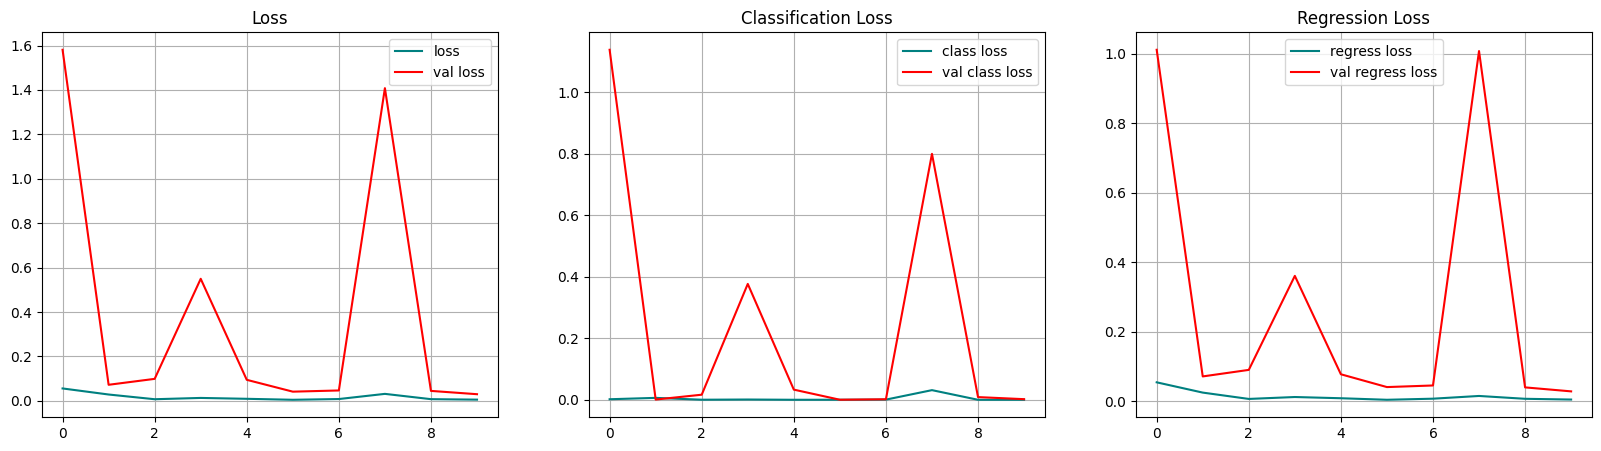

In [16]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

#loss - przewidywanie poprawnych wyników dla zbioru treningowego, vall loss - przewidywanie poprawnych wyników dla zbioru walidacyjnego
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='red', label='val loss')
ax[0].grid('on')
ax[0].title.set_text('Loss')
ax[0].legend()

#class loss - przewidywanie czy twarz jest na obrazie dla zbioru treningowego, vall loss - przewidywanie czy twarz jest na obrazie dla zbioru walidacyjnego
ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='red', label='val class loss')
ax[1].grid('on')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

#regress loss - przewidywanie poprawnych lokalizacji koordynatów dla zbioru trenigowego, val regress loss - przewidywanie poprawnych lokalizacji koordynatów dla zbioru walidacyjnego
ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='red', label='val regress loss')
ax[2].grid('on')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 8. Sprawdzenie jakości detekcji

4/4 [==============================] - 4s 886ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

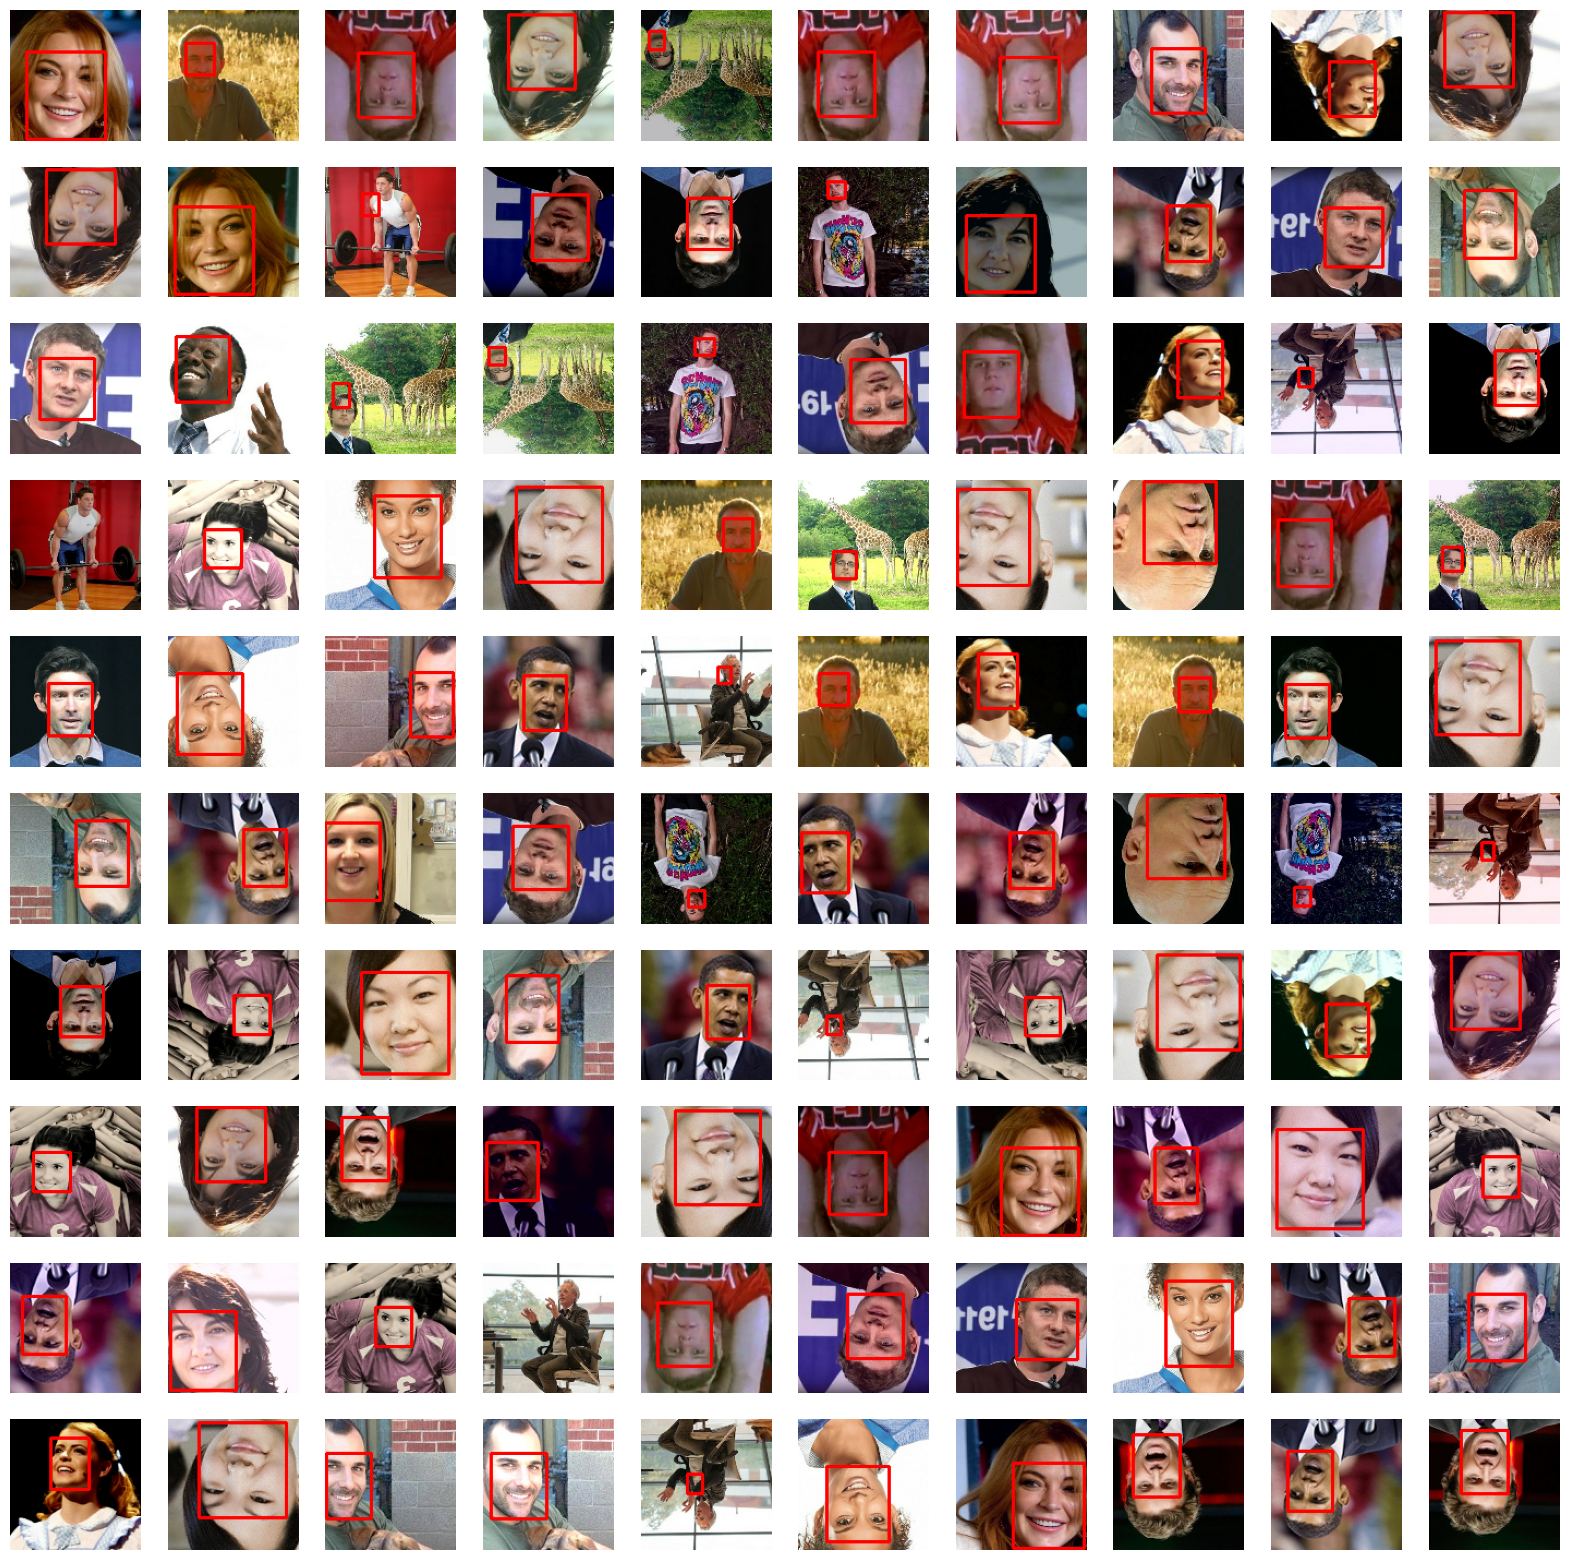

In [17]:
#import pakietów
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

facetracker = load_model('model.h5')

#przygotowanie danych wejściowych
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

#wyświetlenie 100 zdjęć wraz z przewidywaniami sieci
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20,20))
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        sample_image = test_sample[0][idx]
        sample_coords = yhat[1][idx]
        if yhat[0][idx] > 0.9:
            cv2.rectangle(sample_image, 
                          tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                                (255,0,0), 2)
        ax[i][j].imshow(sample_image)
        ax[i][j].axis('off')

plt.show()